# PHY4268 Tutorial 9 - Parameter Quantum Circuits
 1. **S. G. Nana Engo**, serge.nana-engo@facsciences-uy1.cm
    * Department of Physics, Faculty of Science, University of Yaounde I
1. **J-P. Tchapet Njafa**, jean-pierre.tchapet-njafa@univ-maroua.cm
    * Department of Physics, Faculty of Science, University of Maroua
  
June 2024

Dans ce tutoriel, nous apprendrons comment construire des circuits paramétrés et attribuer des valeurs aux paramètres de circuit dans Qiskit. Ces circuits sont utilisés pour les *ansatz* de type HEA.

## Construire un circuit paramétré

La création d'un circuit quantique avec des paramètres dans Qiskit n'est pas très différente de la création d'un circuit quantique standard. Nous initialisons simplement les paramètres à l'aide de la classe `qiskit.circuit.Parameter`  et les utilisons en conséquence lors de l'ajout de portes au circuit construit. 

Dans l'exemple suivant, nous utilisons des paramètres pour l'angle de rotation des portes quantiques rotationnelles.

In [1]:
import qiskit
qiskit.__version__ 

'1.1.0'

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

import numpy as np

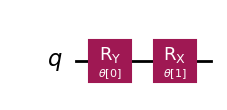

In [6]:
#Parameters are initialized with a simple string identifier
parameter_0 = Parameter('$\\theta$[0]')
parameter_1 = Parameter('$\\theta$[1]')
circuit = QuantumCircuit(1)

#We can then pass the initialized parameters as the rotation angle argument to the Rx and Ry gates
circuit.ry(theta = parameter_0, qubit = 0)
circuit.rx(theta = parameter_1, qubit = 0)
circuit.draw('mpl')

Le même paramètre peut également être utilisé plusieurs fois dans le même circuit. Considérez la forme du circuit comme ci-dessus, mais avec le même paramètre utilisé à plusieurs reprises pour différentes portes.

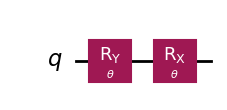

In [8]:
parameter = Parameter('$\\theta$')
circuit = QuantumCircuit(1)
circuit.ry(theta = parameter, qubit = 0)
circuit.rx(theta = parameter, qubit = 0)
circuit.draw('mpl')

Pour plus de commodité, il existe également une classe `qiskit.circuit.ParameterVector` qui permet la création de plusieurs paramètres à la fois. Considérons l'exemple suivant d'un circuit `qiskit.circuit.library.RealAmplitudes`, qui consiste en une alternance de couches de portes $R_Y$ paramétrées et de portes $CX$ intriquées. La forme variationnelle [RealAmplitudes](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RealAmplitudes.html) est couramment utilisée pour la classification dans l'apprentissage automatique quantique.

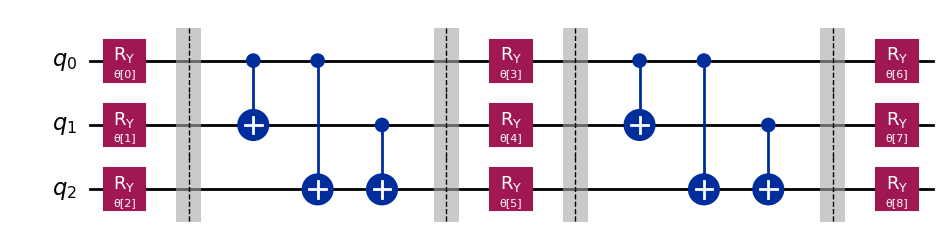

In [9]:
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
ansatz = RealAmplitudes(3, entanglement='full', reps=2, insert_barriers=True) 
# "reps" indicates the number of repetitions of the entanglement.
ansatz.decompose().draw('mpl')

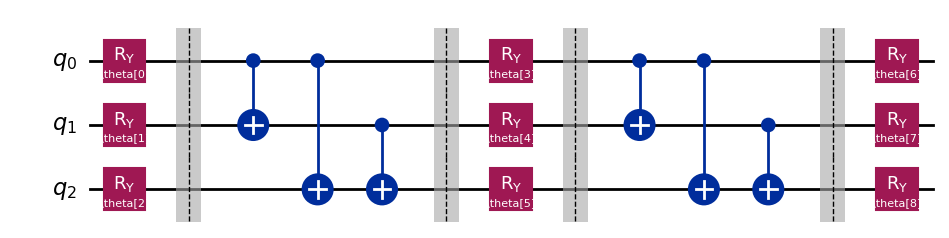

In [10]:
#Set the number of layers and qubits
n=3
num_layers = 2

#ParameterVectors are initialized with a string identifier and an integer specifying the vector length
parameters = ParameterVector('\\theta', n*(num_layers+1))


circuit = QuantumCircuit(n)
for layer in range(num_layers):
    #Appending the parameterized Ry gates using parameters from the vector constructed above
    for i in range(n):
        circuit.ry(parameters[n*layer+i], i)
    circuit.barrier()

    #Appending the entangling CNOT gates
    for i in range(n):
        for j in range(i):
                circuit.cx(j,i)
    circuit.barrier()

#Appending one additional layer of parameterized Ry gates
for i in range(n):
    circuit.ry(parameters[n*num_layers+i], i)

circuit.draw('mpl')

Nous pouvons inspecter les paramètres qui font partie du circuit quantique.

In [11]:
circuit.parameters

ParameterView([ParameterVectorElement(\theta[0]), ParameterVectorElement(\theta[1]), ParameterVectorElement(\theta[2]), ParameterVectorElement(\theta[3]), ParameterVectorElement(\theta[4]), ParameterVectorElement(\theta[5]), ParameterVectorElement(\theta[6]), ParameterVectorElement(\theta[7]), ParameterVectorElement(\theta[8])])

## Attribution de valeurs aux paramètres
Un circuit paramétré ne peut pas être exécuté sur un backend quantique tant que les paramètres n'ont pas reçu de valeurs fixes. Pour ce faire, nous pouvons utiliser les méthodes `QuantumCircuit`
```
assign_parameters(parameters, inplace = False)
bind_paramètres(valeurs)
```
`bind_parameters` attribue des valeurs numériques aux paramètres du circuit, produisant toujours un nouveau circuit. Avec `assign_parameters`, on peut assigner des valeurs numériques ou substituer des paramètres par d'autres expressions de paramètres. De plus, avec `assign_parameters`, il est possible de remplacer les paramètres en place au lieu de générer un nouveau circuit. Les valeurs ou expressions de paramètres qui doivent être affectées aux paramètres du circuit peuvent être fournies soit sous forme de dictionnaire, où les clés de dictionnaire correspondent aux paramètres du circuit et les valeurs de dictionnaire sont les valeurs à lier, soit sous forme d'itérable de valeurs. Dans ce dernier cas, les valeurs sont attribuées aux paramètres dans le même ordre que les paramètres ont été ajoutés au circuit.

In [12]:
#Create parameter dictionary with random values to bind
param_dict = {parameter: np.random.random() for parameter in parameters}
param_dict

{ParameterVectorElement(\theta[0]): 0.33466412791689826,
 ParameterVectorElement(\theta[1]): 0.9775370648861954,
 ParameterVectorElement(\theta[2]): 0.43883325990902655,
 ParameterVectorElement(\theta[3]): 0.6868017700068486,
 ParameterVectorElement(\theta[4]): 0.3079605112596042,
 ParameterVectorElement(\theta[5]): 0.255514391195661,
 ParameterVectorElement(\theta[6]): 0.9887347484983612,
 ParameterVectorElement(\theta[7]): 0.1373479403608049,
 ParameterVectorElement(\theta[8]): 0.8052936395676353}

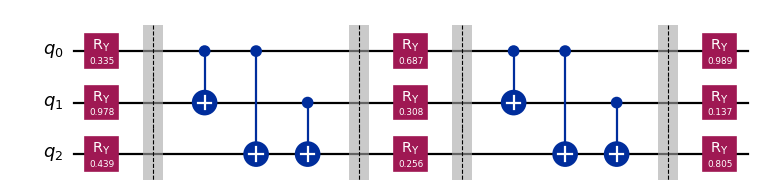

In [13]:
#Assign parameters using the assign_parameters method
bound_circuit = circuit.assign_parameters(parameters = param_dict)
bound_circuit.draw('mpl',scale=.8)

Considérons également le circuit suivant, où nous substituons un paramètre du circuit d'origine par une autre expression de paramètre.

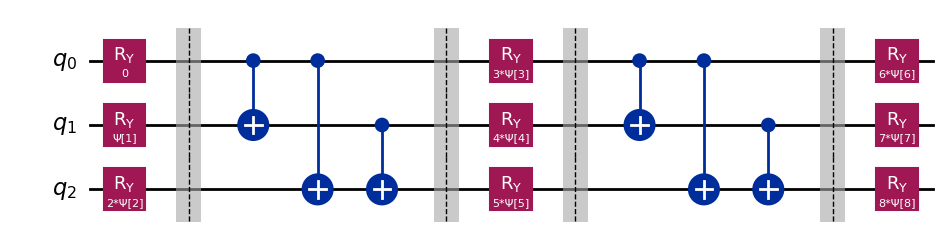

In [14]:
new_parameters = ParameterVector('Ψ',9)
new_circuit = circuit.assign_parameters(parameters = [k*new_parameters[k] for k in range(9)])
new_circuit.draw('mpl')

La version liée (bound) du circuit peut maintenant être exécutée sur un dispositif quantique. Tenter d'exécuter un circuit quantique paramétré avec des paramètres non assignés générera une erreur.

## Quelques circuits de `qiskit.circuit.library`

Pour la resolution des d'optimisation et de calculs variationnels, il existe une classe de fonctions d'essai ou de circuits quantiques paramétrés connue sous l'appellation **Hardware Efficient Ansatz (HEA)**. Un HEA correspond à un état fortement intriqué obtenu dans le cadre d'une approche heuristique. Nous presentons ici quelques uns de implémentés dans `qiskit.circuit.library`.

### `qiskit.circuit.library.RealAmplitudes`

Le circuit `RealAmplitudes` se compose de couches alternées de rotations $\mathtt{R}_Y(\theta)$ et d'intrication $\mathtt{CX}$. Le motif d'intrication peut être défini par l'utilisateur ou sélectionné dans un ensemble prédéfini. On l'appelle `RealAmplitudes` parce que les états quantiques préparés n'auront que des amplitudes réelles, la partie complexe étant toujours nulle.

Les strategies d'intrication sont les suivantes:

* `full` pour l'intrication de chaque 1-qubit avec tous les autres; </br>
* `linear` pour l'intrication du 1-qubit $i$ avec le 1-qubit $i+1$ avec $i\in\{0,1,\ldots,n-2\}$, $n$ étant le nombre total de 1-qubits;</br>
* `reverse_linear` pour l'intrication 1-qubit $i$ avec le 1-qubit $i+1$ avec $i\in\{n-2, n-3, \ldots,1,0\}$, $n$ étant le nombre total de 1-qbuits. Noter que si entanglement_blocks = `cx` alors cette option fournit le même opérateur unitaire que `full`' avec moins de portes d'intrication;</br>
* `pairwise` pour l'intrication d'une couche 1-qubit $i$ avec le 1-qubit $i+1$ pour toutes les valeurs paires de $i$, puis une deuxième couche où un 1-qubit $i$ avec le 1-qubit $i+1$ pour toutes les valeurs impaires de $i$;</br>
* `circular` pour l'intrication linéaire avec une intrication supplémentaire du premier et du dernier qubit avant la partie linéaire;</br>
*  entanglement is linear entanglement but with an additional entanglement of the first and last qubit before the linear part.

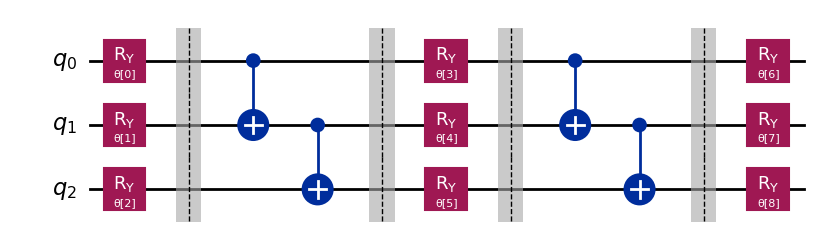

In [15]:
ansatz1 = RealAmplitudes(3, entanglement='linear', reps=2, insert_barriers=True)
ansatz1.decompose().draw('mpl') # decompose the layers into standard gates

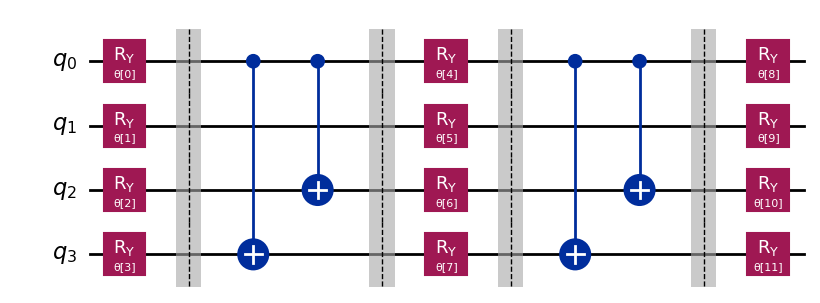

In [16]:
ansatz2 = RealAmplitudes(4, entanglement=[[0,3], [0,2]],
 reps=2, insert_barriers=True)
ansatz2.decompose().draw('mpl')

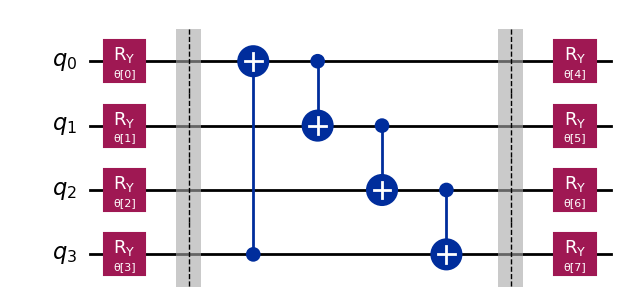

In [17]:
ansatz3 = RealAmplitudes(4, reps=1, entanglement='circular', insert_barriers=True)
ansatz3.decompose().draw('mpl')

### `qiskit.circuit.library.TwoLocal`

C'est bibliothèque de circuits dont `RealAmplitudes` est un cas particulier. Les portes de rotation et d'intrication peuvent être spécifiées comme 
* chaîne (par exemple 'ry' ou 'cx'), 
* type de porte (par exemple RYGate ou CXGate),
* QuantumCircuit (par exemple un circuit à 1 qubit ou à 2 qubit).

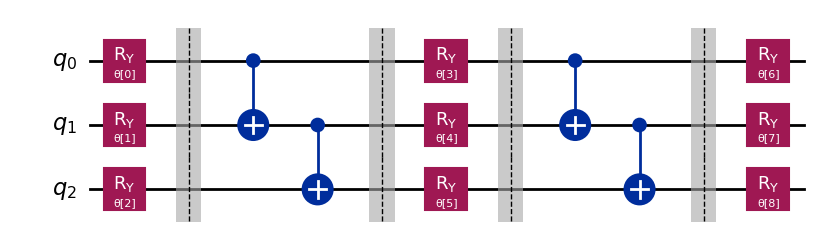

In [18]:
from qiskit.circuit.library import TwoLocal

two1 = TwoLocal(3, 'ry', 'cx', 'linear', reps=2, insert_barriers=True)
two1.decompose().draw('mpl')

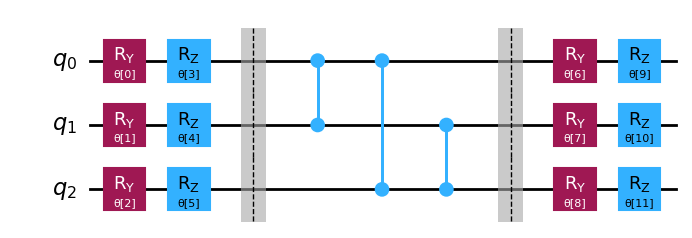

In [19]:
two2 = TwoLocal(3, ['ry','rz'], 'cz', 'full', reps=1, insert_barriers=True)
two2.decompose().draw('mpl')

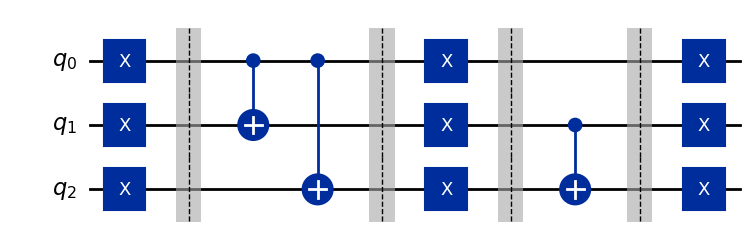

In [20]:
layer_1 = [(0, 1), (0, 2)]
layer_2 = [(1, 2)]
two3 = TwoLocal(3, 'x', 'cx', [layer_1, layer_2], reps=2, insert_barriers=True)
two3.decompose().draw('mpl')

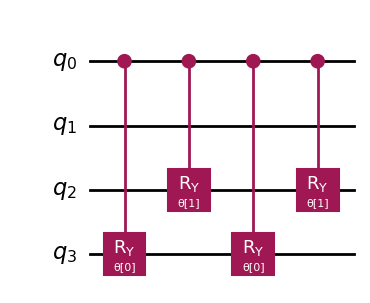

In [21]:
entangler_map = [[0, 3], [0, 2]]  # entangle the first and last two-way
two4 = TwoLocal(4, [], 'cry', entangler_map, reps=1)
circuit = two4.compose(two4)
circuit.decompose().draw('mpl')  # note, that the parameters are the same!

### `qiskit.circuit.library.EfficientSU2`

Le circuit `EfficientSU2` se compose de couches d'opérations 1-qubit SU(2) et d'intrications. SU(2) signifie groupe unitaire spécial de degré 2, ses éléments sont des matrices unitaires avec déterminant 1, telles que les portes de rotation de Pauli.

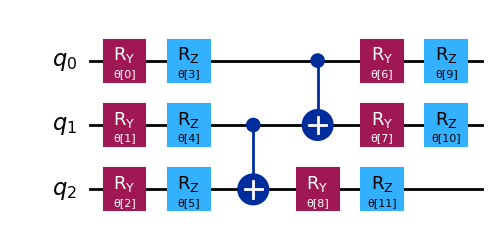

In [22]:
from qiskit.circuit.library import EfficientSU2

SU2ansatz1 = EfficientSU2(3, reps=1)
SU2ansatz1.decompose().draw('mpl')

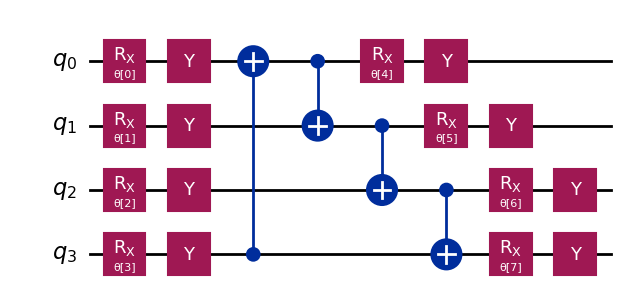

In [23]:
SU2ansatz2 = EfficientSU2(4, su2_gates=['rx', 'y'], entanglement='circular', reps=1)
SU2ansatz2.decompose().draw('mpl')

## Quantum Feature Map

Un *Quantum Feature Map* mappe de manière non linéaire une donnée classique **x** à un état quantique $|\Phi(\mathbf{x})\rangle\langle\Phi(\mathbf{x})|$, un vecteur dans le Hilbert espace des matrices des opérateurs statistiques. Par exemple, les classificateurs **Support Vector Machines** trouvent un hyperplan séparant chaque vecteur $|\Phi(\mathbf{x}_i)\rangle\langle\Phi(\mathbf{x}_i)|$ en fonction de son étiquette, pris en charge par une quantité réduite de vecteurs (les vecteurs dits de support). Un élément clé de la *feature map* n'est pas seulement l'utilisation de l'espace d'état quantique comme espace de caractéristiques, mais également la manière dont les données sont mappées dans cet espace de grande dimension.

La construction de *features map* basées sur des circuits quantiques difficiles à simuler de manière classique est une étape importante vers l'obtention d'un avantage quantique par rapport aux approches classiques. [Havlicek _et al_.](https://arxiv.org/abs/1804.11326) ont proposé une famille de *features map* qui est supposée difficile à simuler de manière classique et qui peut être implémentée sous forme de circuits à courte profondeur sur des dispositifs quantiques NISQ. Une *quantum feature map* de profondeur $d$ est implémentée par l'opérateur unitaire

$$ \mathcal{U}_{\Phi(\mathbf{x})}=\prod_d U_{\Phi(\mathbf{x})}H^{\otimes n},\ U_{\Phi(\mathbf {x})}=\exp\left(i\sum_{S\subseteq[n]}\phi_S(\mathbf{x})\prod_{k\in S} P_k\right), $$

qui contient des couches de portes Hadamard entrelacées avec des blocs d'intrications codant les données classiques comme indiqué dans le schéma de circuit ci-dessous pour $d=2$.

<center><img src="./Graphics/uphi.PNG" width="400" /></center>

Le nombre de qubits $n$ dans le circuit quantique est égal à la dimensionnalité des données classiques $\mathbf{x}$, qui sont codées par les coefficients $\phi_S(\mathbf{x})$, où $S \subseteq[n] = \{1, \ldots, n \}$. Nous appelons le développement d'ordre $r$-ième la *features map* de cette famille de circuits lorsque $|S|\leq r$. Dans `qiskit.circuit.library.ZZFeatureMap`, la valeur par défaut est le développement du second ordre $|S|\leq 2$, ce qui donne $n$ singeltons $S=\{i\}$ et, selon le graphe de connectivité du dispositif quantique, jusqu'à $\tfrac{n(n-1)}{2}$ couples pour coder les interactions non linéaires. Plus la borne supérieure $r$ est grande, plus les interactions seront prises en compte.

Seules les contributions des portes $Z$ et $ZZ$ dans les blocs d'intrication sont considérées dans l'article de Havlicek _et al_. En général, les blocs peuvent être exprimés en termes de portes de Pauli $P_k \in \{\mathbb{1}_k, X_k, Y_k, Z_k \}$.

### `qiskit.circuit.library.ZZFeatureMap`

Ce sont des circuits du second ordre ($|S|\leq 2$) de  Pauli (`PauliFeatureMap`). Ils ont les mêmes paramètres tels que `reps` et `data_map_function` ainsi qu'un paramètre `paulis` supplémentaire pour modifier le jeu de portes. Ce paramètre est une liste de chaînes, chacune représentant la ou les portes Pauli souhaitées. La valeur  `pauli=['Z', 'ZZ']`, qui équivaut à `ZZFeatureMap`. Il est à noter que les paramètres par défaut pour `data_map_func` dans `ZZFeatureMap` sont donnés par 

$$ \phi_S:x\mapsto \begin{cases} x_i & \text{if}\ S=\{i\} \\ (\pi-x_i)(\pi-x_j) & \text{if}\ S=\{i,j\}\end{cases} .$$

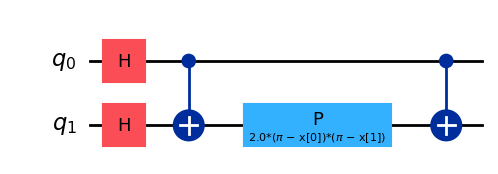

In [24]:
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap

prep0 = PauliFeatureMap(2, reps=1, paulis=['ZZ'])
prep0.decompose().draw('mpl')

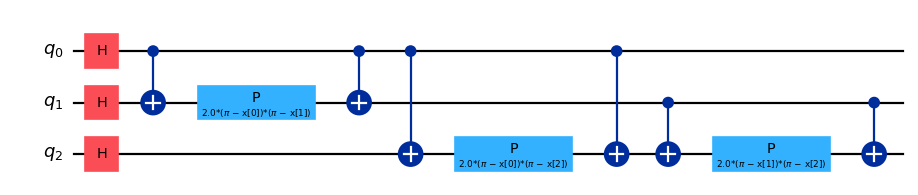

In [25]:
prep1 = PauliFeatureMap(3, reps=1, paulis=['ZZ'])
prep1.decompose().draw('mpl', scale=.8)

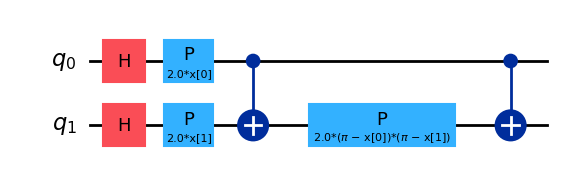

In [26]:
prep2 = PauliFeatureMap(2, reps=1, paulis=['Z','ZZ'])
prep2.decompose().draw('mpl')

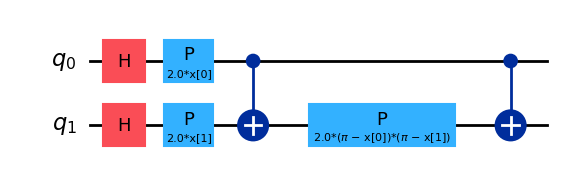

In [27]:
prep3 = ZZFeatureMap(2, reps=1)
prep3.decompose().draw('mpl')

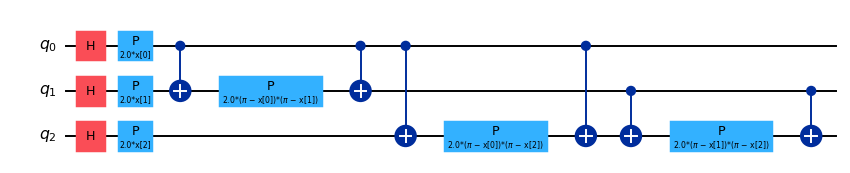

In [28]:
prep4 = PauliFeatureMap(3, reps=1, paulis=['Z','ZZ'])
prep4.decompose().draw('mpl', scale=.7)

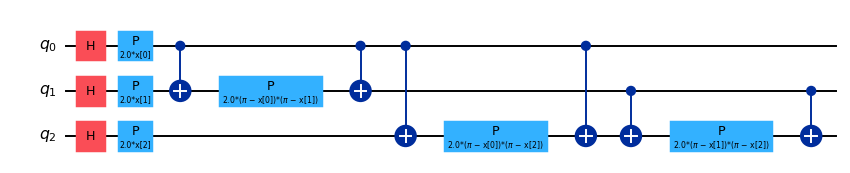

In [29]:
prep5 = ZZFeatureMap(3, reps=1)
prep5.decompose().draw('mpl', scale=.7)

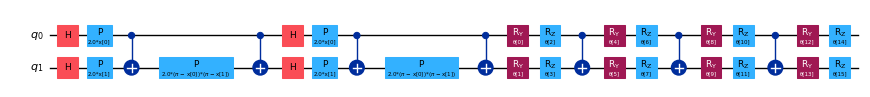

In [30]:
classifier = ZZFeatureMap(2).compose(EfficientSU2(2))
classifier.decompose().draw('mpl',scale=.5)

In [31]:
classifier.num_parameters

18